In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pathlib import Path
import networkx as nx

json_path = Path("../out/tracked.json")

with open(json_path, encoding='utf-8') as f:
    data = json.load(f)
    job_data = data["jobs"]
    person_data = data["persons"]

person_lookup = {person['id']: person for person in person_data}



In [2]:
def get_job_all_metadata(job_ids_str):
    job_ids = [str(job_id).strip() for job_id in str(job_ids_str).split(",")]
    metadata_list = []

    for job_id in job_ids:
        job_info = job_data.get(job_id)
        metadata_list.append(job_info)
    return metadata_list

def get_census_jobs_and_years(person_id):
    """Return list of (job, census_year) for a person, skipping null jobs."""
    result = []
    person = person_lookup.get(person_id)
    if not person:
        return result
    for entry in person.get("census_entries", []):
        job = entry.get("job")
        year = entry.get("census_year")
        result.append((job, year))
    return result


        

In [ ]:
def best_activity(metadatas):
    best_activity = 'no activity'
    best_score = 0
    for meta in metadatas:
        if meta is not None:
            sector = meta.get('sector')
            category = meta.get('categorie')

            score = 0
            if sector:
                score += 1
            else:
                sector = 'no sector'
            if category:
                score += 1
            else:
                category = ''
            if score > best_score:
                best_score = score  # Don't forget to update the best_score!
                best_activity = sector + ' ' + category
        
    if best_activity == 'no activity':
        for meta in metadatas:
            if meta is not None:
                job = meta.get('job')
                if job in ['rentiere', 'rentier', 'proprietaire', 'proprietaire', 'propriétaire', 'rentière', 'propriétaire']:
                    best_activity = 'propriétaire'
                    continue
                # if job in ['sans vocation']:
                #     best_activity = 'sans vocation'
                #     continue


    return best_activity


def best_year(years):
    if len(years) > 0:
        return min(years)
    else:
        return 2020

In [4]:
def build_activity_transition_graph():
    node_weights = defaultdict(int)  # key: node name, value: weight
    edge_weights = defaultdict(int)  # key: (parent_node, child_node), value: weight

    
    no_parents = 0
    child_no_job = 0
    parent_no_job = 0
    child_no_metadata = 0
    parent_no_metadata = 0
    child_no_activity = 0
    parent_no_activity = 0
    missing_jobs = {}

    for person in person_data:
        parent_id = person.get('parent')
        if not parent_id:
            no_parents += 1
            continue
        parent = person_lookup.get(parent_id)

        #child
        job_ids = person.get("job_ids")
        if len(job_ids) < 1:
            child_no_job += 1
            continue
        jobs_metadata = [job_data.get(str(job_id).strip()) for job_id in job_ids]
        if len(jobs_metadata) == 0:
            child_no_metadata += 1
        jobs = []
        years = []
        for entry in person.get("census_entries", []):
            jobs.append(entry.get("job"))
            years.append(entry.get("census_year"))
        child_activity = best_activity(jobs_metadata)
        if child_activity == 'no activity':
            child_no_activity += 1
            for job in jobs:
                missing_jobs[job] = missing_jobs.get(job, 0) + 1
            continue
        child_year = best_year(years)

        # parent
        parent_job_ids = parent.get("job_ids")
        if len(parent_job_ids) < 1:
            parent_no_job += 1
            continue
        parent_jobs_metadata = [job_data.get(str(job_id).strip()) for job_id in parent_job_ids]
        if len(parent_jobs_metadata) == 0:
            parent_no_metadata += 1
        parent_jobs = []
        parent_years = []
        for entry in parent.get("census_entries", []):
            parent_jobs.append(entry.get("job"))
            parent_years.append(entry.get("census_year"))
        parent_activity = best_activity(parent_jobs_metadata)
        if parent_activity == 'no activity':
            parent_no_activity += 1
            for job in parent_jobs:
                missing_jobs[job] = missing_jobs.get(job, 0) + 1
            continue
        parent_year = best_year(parent_years)




        parent_node = f"parent: {parent_activity}"
        child_node = f"child: {child_activity}"

        # Increment node weights
        node_weights[parent_node] += 1
        node_weights[child_node] += 1

        # Increment edge weight
        edge_weights[(parent_node, child_node)] += 1

    print(f"{len(person_data)} persons processed")
    print(no_parents, "persons with no parent")
    print(child_no_job, "children with no job")
    print(parent_no_job, "parents with no job")
    print(child_no_metadata, "children with no job metadata")
    print(parent_no_metadata, "parents with no job metadata")
    print(child_no_activity, 'children with no activty')
    print(parent_no_activity, 'parents with no activity')
    print('problematic jobs: ')
    sorted_dict = dict(sorted(missing_jobs.items(), key=lambda item: item[1], reverse=True))
    print(sorted_dict)


    
    

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes
    for node, weight in node_weights.items():
        node_type = "parent" if node.startswith("parent:") else "child"
        activity = node.split(": ", 1)[1]
        G.add_node(node, type=node_type, activity=activity, weight=weight)

    # Add edges with weights
    for (parent_node, child_node), weight in edge_weights.items():
        G.add_edge(parent_node, child_node, weight=weight)

    return G

# Usage example:
G = build_activity_transition_graph()

# Save to GEXF file (optional)
nx.write_gexf(G, "activity_transition_graph.gexf", encoding='utf-8', prettyprint=True)






4728 persons processed
2293 persons with no parent
0 children with no job
0 parents with no job
0 children with no job metadata
0 parents with no job metadata
27 children with no activty
396 parents with no activity
problematic jobs: 
{'propriétaire': 33, 'proprietaire': 31, 'tient pension': 12, 'fontenier': 12, 'conducteur': 11, 'concierge': 10, 'employe au chateau': 10, 'relieur': 9, 'ecrivain': 8, 'fontainier': 8, 'douanier': 5, 'limonadier': 5, 'comptable': 5, 'mtre macon': 4, 'ebeniste': 4, 'coutelier': 3, 'commission de la 4e division': 3, 'marguiller': 3, 'basteur': 3, 'fabricant de miroirs': 3, 'employe': 3, 'sergent de ville': 3, 'commissaire des guerres': 3, 'negociant|vetirinaire': 3, 'gypseur': 3, 'empa la gare': 3, 'directeur': 3, 'eufelier': 3, 'fermier|pie': 3, 'taillandier': 3, 'femme de ménage': 2, 'cartonnier': 2, 'marguillier': 2, 'cultive ses terres': 2, 'fontenier et entrepreneur': 2, 'fabricant de casquettes': 2, 'instructeur chef': 2, 'piqueur': 2, 'constructeur'

In [5]:
def graph_to_transition_matrix(G):
    """
    Given a NetworkX DiGraph G with edge weights,
    returns the transition matrix (as a numpy array)
    and the list of node labels (in matrix order).
    """
    nodes = list(G.nodes())
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    M = np.zeros((n, n))

    for i, src in enumerate(nodes):
        out_edges = G.out_edges(src, data='weight', default=1)
        total_weight = sum(weight for _, _, weight in out_edges)
        if total_weight > 0:
            for _, dst, weight in out_edges:
                j = node_index[dst]
                M[i, j] = weight / total_weight
        # If no outgoing edges, row remains zeros (could set self-loop if desired)

    return M, nodes


    


4728 persons processed
2293 persons with no parent
0 children with no job
0 parents with no job
0 children with no job metadata
0 parents with no job metadata
27 children with no activty
396 parents with no activity
problematic jobs: 
{'propriétaire': 33, 'proprietaire': 31, 'tient pension': 12, 'fontenier': 12, 'conducteur': 11, 'concierge': 10, 'employe au chateau': 10, 'relieur': 9, 'ecrivain': 8, 'fontainier': 8, 'douanier': 5, 'limonadier': 5, 'comptable': 5, 'mtre macon': 4, 'ebeniste': 4, 'coutelier': 3, 'commission de la 4e division': 3, 'marguiller': 3, 'basteur': 3, 'fabricant de miroirs': 3, 'employe': 3, 'sergent de ville': 3, 'commissaire des guerres': 3, 'negociant|vetirinaire': 3, 'gypseur': 3, 'empa la gare': 3, 'directeur': 3, 'eufelier': 3, 'fermier|pie': 3, 'taillandier': 3, 'femme de ménage': 2, 'cartonnier': 2, 'marguillier': 2, 'cultive ses terres': 2, 'fontenier et entrepreneur': 2, 'fabricant de casquettes': 2, 'instructeur chef': 2, 'piqueur': 2, 'constructeur'

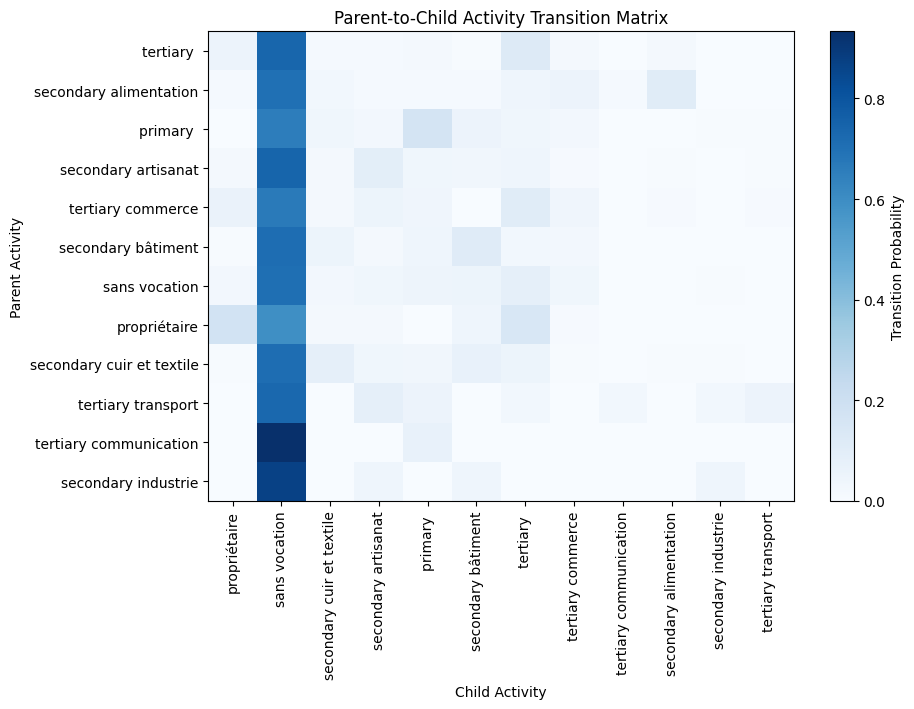

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Build the graph
G = build_activity_transition_graph()

# Get transition matrix and node labels
M, nodes = graph_to_transition_matrix(G)

# Separate parent and child nodes for labeling
parent_nodes = [n for n in nodes if G.nodes[n]['type'] == 'parent']
child_nodes = [n for n in nodes if G.nodes[n]['type'] == 'child']

# Build index mapping for matrix slicing
parent_indices = [nodes.index(n) for n in parent_nodes]
child_indices = [nodes.index(n) for n in child_nodes]

# Extract the relevant submatrix: parents (rows) to children (columns)
transition_submatrix = M[np.ix_(parent_indices, child_indices)]

# Get activity labels for axes
parent_labels = [G.nodes[n]['activity'] for n in parent_nodes]
child_labels = [G.nodes[n]['activity'] for n in child_nodes]

# Plot the transition matrix as a heatmap
plt.figure(figsize=(max(8, len(child_labels)*0.8), max(6, len(parent_labels)*0.6)))
im = plt.imshow(transition_submatrix, aspect='auto', cmap='Blues')

plt.colorbar(im, label='Transition Probability')
plt.xticks(ticks=np.arange(len(child_labels)), labels=child_labels, rotation=90)
plt.yticks(ticks=np.arange(len(parent_labels)), labels=parent_labels)
plt.xlabel('Child Activity')
plt.ylabel('Parent Activity')
plt.title('Parent-to-Child Activity Transition Matrix')

plt.tight_layout()
plt.show()


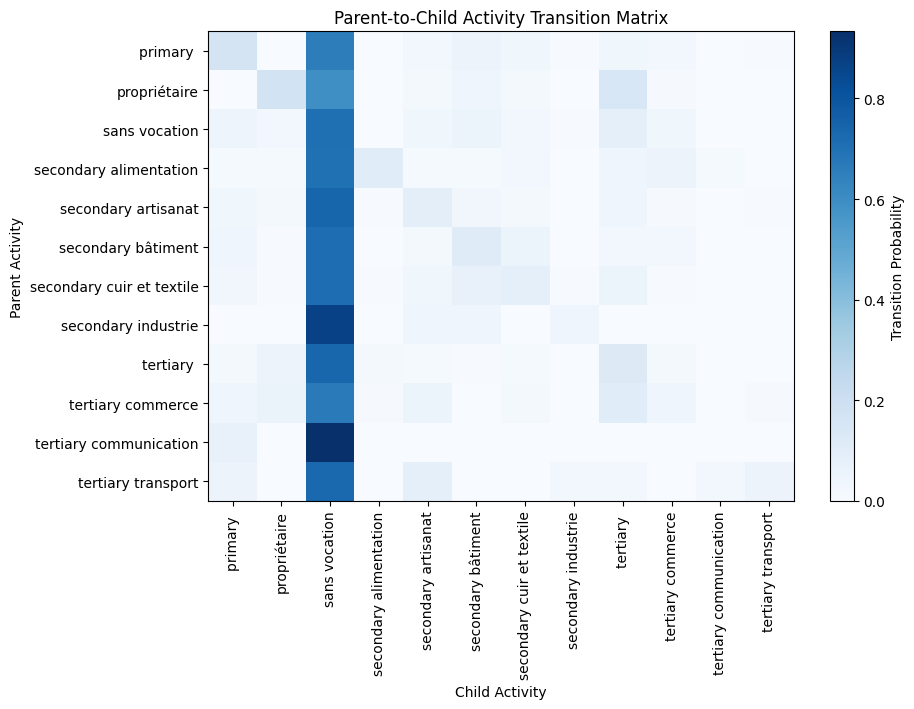

In [9]:
# Sort parent and child nodes alphabetically by activity
parent_nodes_sorted = sorted(parent_nodes, key=lambda n: G.nodes[n]['activity'])
child_nodes_sorted = sorted(child_nodes, key=lambda n: G.nodes[n]['activity'])

# Get new indices for the sorted nodes
parent_indices_sorted = [nodes.index(n) for n in parent_nodes_sorted]
child_indices_sorted = [nodes.index(n) for n in child_nodes_sorted]

# Extract the sorted submatrix
transition_submatrix_sorted = M[np.ix_(parent_indices_sorted, child_indices_sorted)]

# Get sorted activity labels for axes
parent_labels_sorted = [G.nodes[n]['activity'] for n in parent_nodes_sorted]
child_labels_sorted = [G.nodes[n]['activity'] for n in child_nodes_sorted]

# Plot the sorted transition matrix as a heatmap
plt.figure(figsize=(max(8, len(child_labels_sorted)*0.8), max(6, len(parent_labels_sorted)*0.6)))
im = plt.imshow(transition_submatrix_sorted, aspect='auto', cmap='Blues')

plt.colorbar(im, label='Transition Probability')
plt.xticks(ticks=np.arange(len(child_labels_sorted)), labels=child_labels_sorted, rotation=90)
plt.yticks(ticks=np.arange(len(parent_labels_sorted)), labels=parent_labels_sorted)
plt.xlabel('Child Activity')
plt.ylabel('Parent Activity')
plt.title('Parent-to-Child Activity Transition Matrix')

plt.tight_layout()
plt.show()
